In [1]:
using PyPlot, FFTW, LinearAlgebra

In [2]:
const TYPE = BigFloat
function lag(x,y,N) 
    θ = acos(x)
    θn = acos(y)
    θ == θn ? one(typeof(x)) : (sin(N*(θ-θn))/tan((θ-θn)/2) + sin(N*(θ+θn))/tan((θ+θn)/2))/2N
end

lag (generic function with 1 method)

In [3]:
lag.(chebypts(10),chebypts(10)',10)

LoadError: UndefVarError: chebypts not defined

In [4]:
g_raw(x,i) = 1/(x+i)
g(x,i) = 2g_raw((x+1)/2,i) - 1
expφ(x,i) = 4/(x+1+2i)^2
chebypts(N) = cos.((TYPE(pi)*(1:2:2N))/2N)
function gibbsmeasure(N)
    xpts = chebypts(N)
    L = [sum(lag(g(x,i),y,N)*expφ(x,i) for i = 2:6) for x in xpts, y in xpts]
    
    Iterations = ceil(Int,1.5 * log(0.5,eps(TYPE)))
    eig1_guess_l = [1;zeros(TYPE,N-1)]
    eig1_guess_r = [1;zeros(TYPE,N-1)]
    nm = TYPE(Inf); nm_mid = TYPE(Inf)
    for i = 1:Iterations
        eig1_guess_l = L'*eig1_guess_l
        nm = norm(eig1_guess_l)
        eig1_guess_l /= nm
        (i == div(3Iterations,4)) && (nm_mid = nm)
        (i == Iterations) && (@assert abs(nm-nm_mid) < 1000N*eps(TYPE))

        eig1_guess_r = L*eig1_guess_r
        eig1_guess_r /= dot(eig1_guess_l,eig1_guess_r)

    end
    μ = (eig1_guess_r.*eig1_guess_l)/sum(eig1_guess_r.*eig1_guess_l)
    μ, eig1_guess_r, nm
end

gibbsest(N) = sum(gibbsmeasure(N)[1].*(1 .+chebypts(N))/2)

gibbsest (generic function with 1 method)

In [5]:
Ns = 1:30
geInf = gibbsest(50)
ges = [gibbsest(N) for N in Ns];
expPInf = gibbsmeasure(50)[3]

0.3883795610880237304908992029072214364786209164213502549676712634502832365996428

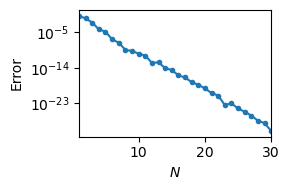

In [6]:
figure(figsize=(3,2))
semilogy(Ns,Float64.(abs.(ges .- geInf)),".-")
    xlim(extrema(Ns))
    xlabel("\$N\$")
ylabel("Error")
tight_layout()
savefig("../figures/Convergence.pdf")

In [7]:
gm200 = Float64.(gibbsmeasure(200)[1])
cpts200 = Float64.(chebypts(200));

In [8]:
gibbsfunc(x) = 200/pi/sqrt(1-x^2)*sum(gp*lag(x,y,200) for (gp,y) in zip(gm200,cpts200))

gibbsfunc (generic function with 1 method)

In [9]:
r = Float64.(gibbsmeasure(10)[2])
cpts10 = Float64.(chebypts(10))
rfunc(x) = sum(rp*lag(x,y,10) for (rp,y) in zip(r,cpts10))

rfunc (generic function with 1 method)

In [10]:
T = 10^6
T0 = 10^4
x = 0.
for t = 1:T0
    probs = [expφ(x,i)*rfunc(g(x,i))/rfunc(x) for i = 2:6]
#         println(probs)
    edges = cumsum(probs)/sum(probs)
        i = 1 .+findfirst(edges.>rand())
    x = g(x,i)
#         println(i)
end
xh = Array{Float64}(undef,T)
for t = 1:T
    probs = [expφ(x,i)*rfunc(g(x,i))/rfunc(x) for i = 2:6]
    edges = cumsum(probs)/sum(probs)
    x = g(x,1 .+findfirst(edges.>rand()))
    xh[t] = x
end

In [11]:
using SparseArrays
getind(x,N) = max(ceil(Int,x*N),1)

function gibbsmeasure_ulam(N)
    I = Int[]
    J = Int[]
    W = Float64[]
    for i = 1:N
        for l = 2:6
            xl = (i-1)/N; xu = i/N
            yl = g_raw(xu,l); indl = getind(yl,N)
            yu = g_raw(xl,l); indu = getind(yu,N)
            @assert yl < yu
            @assert indl <= indu
            wdth = yu-yl; grad = wdth*N
            wt = grad
            if indl == indu
                push!(I,i); push!(J,indl); push!(W,wt)
            else
                push!(I,i); push!(J,indl); push!(W,wt*(indl/N-yl)/wdth)
                for ind = indl+1:indu-1
                    push!(I,i); push!(J,ind); push!(W,wt/N/wdth)
                end
                push!(I,i); push!(J,indu); push!(W,wt*(yu-(indu-1)/N)/wdth)
            end
        end
    end
    L = sparse(J,I,W,N,N)
    r = ones(N)
    l = ones(N)
    for i = 1:100
        r = L*r
        l = L'*l
        r /= sum(r)
        l /= dot(r,l)
    end
    expP = sum(L*r)/sum(r)
    @assert maximum(abs.(L*r - expP*r)) < 1e-10
    return (r.*l)*N, expP, L
end

gibbsmeasure_ulam (generic function with 1 method)

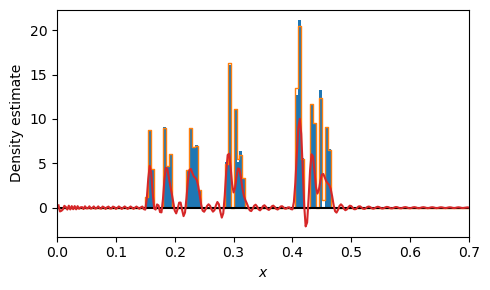

In [21]:
figure(figsize=(5,3))

hist((1 .+xh)/2,bins=(0:0.005:1),density=true,zorder=0)
plot(repeat((0:200)/200,inner=2),[0;repeat(gibbsmeasure_ulam(200)[1],inner=2);0],linewidth=1)
    plot([0,1],[0,0],"k",linewidth=1.5)

plotpts = (-1:0.005:1)
plot((plotpts.+1)/2,[gibbsfunc(x) for x in plotpts],c="C3")
xlim(0,0.7)
xlabel("\$x\$");ylabel("Density estimate")
tight_layout()
savefig("../figures/Visualisation.pdf")